### この実験は選択実験とします．難しい場合はパスしても構いません．

# 実験3-5 自己教師あり学習

自己教師あり学習は，比較的最近に提案された学習手法で，ラベルを必要としない教師なし学習の手法として着目されています．
その基本的な考え方は，

- 同じデータから派生されるデータ拡張は同じ（似たような）表現にマップされるべき
- 異なるデータ（のデータ拡張）は，異なる表現になるべき

というアイディアに基づいた学習手法です．
教師あり学習では，ラベルとよばれる絶対的な指標がありますが，ここでは，表現が似るべきというわりと曖昧なコンセプトに基づいて学習を考えていきます．

ここでは SimCLR （の簡易版）を考えてみます．
キーポイントはデータ拡張の部分にあります．

ここではランダムな，画像切り抜き，フリップ，色補正などを考えています．
データセットとしては `CIFAR10` や `STL10` を考えます．

In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset


# 基本となるデータセットの設定
#base_dataset = datasets.CIFAR10(root="./data", train=True, download=True, transform=None)
base_dataset = datasets.STL10(root="./data", split='train', download=True, transform=None)

#cifar10_labels_map = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
stl10_labels_map = ['airplane', 'bird', 'car', 'cat', 'deer', 'dog', 'horse', 'monkey', 'ship', 'truck']
labels_map = stl10_labels_map

# CIFAR-10 は 32x32 の画像サイズ, STL-10 は 96x96 の画像サイズ
# CIFAR-10 でやる場合は，RandomResizedCrop の size を 32 にする必要がある
# データセットの画像サイズ
SIZE = 96
W, H = SIZE, SIZE

transform_original = transforms.Compose([
    transforms.Resize((SIZE, SIZE)), 
    transforms.ToTensor()
])

transform_1 = transforms.Compose([
    transforms.RandomResizedCrop(size=SIZE),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor()
])

transform_2 = transforms.Compose([
    transforms.RandomResizedCrop(size=SIZE),
    transforms.RandomVerticalFlip(),
    transforms.ToTensor()
])

# データ拡張を適用したデータセットを作成するクラス
class SelfSupervisedDataset(Dataset):
    def __init__(self, base_dataset, transform_1, transform_2):
        """
        Args:
            base_dataset (Dataset): 元となるデータセット（例: STL-10）。
            transform_1 (callable): 1つ目のデータ拡張。
            transform_2 (callable): 2つ目のデータ拡張。
        """
        self.base_dataset = base_dataset
        self.transform_1 = transform_1
        self.transform_2 = transform_2

    def __len__(self):
        return len(self.base_dataset)

    def __getitem__(self, idx):
        img, label = self.base_dataset[idx]  # 元画像とラベルを取得

        # base が PIL 形式であることを仮定
        # なので，ToTensor を base_dataset の段階でとるとしくじる
        # img = transforms.ToPILImage()(img) # tensor -> PILImage

        augmented_1 = self.transform_1(img)  # データ拡張1を適用
        augmented_2 = self.transform_2(img)  # データ拡張2を適用
        return augmented_1, augmented_2, label


#self_supervised_dataset = SelfSupervisedDataset(base_dataset, transform_1, transform_2)
self_supervised_dataset = SelfSupervisedDataset(base_dataset, transform_original, transform_1)

# DataLoaderを作成
dataloader = DataLoader(self_supervised_dataset, batch_size=256, shuffle=True, num_workers=4) # num_workers は適宜変更する．デッドロックの可能性あり

Files already downloaded and verified


Augmented 1 shape: torch.Size([256, 3, 96, 96]), Augmented 2 shape: torch.Size([256, 3, 96, 96])


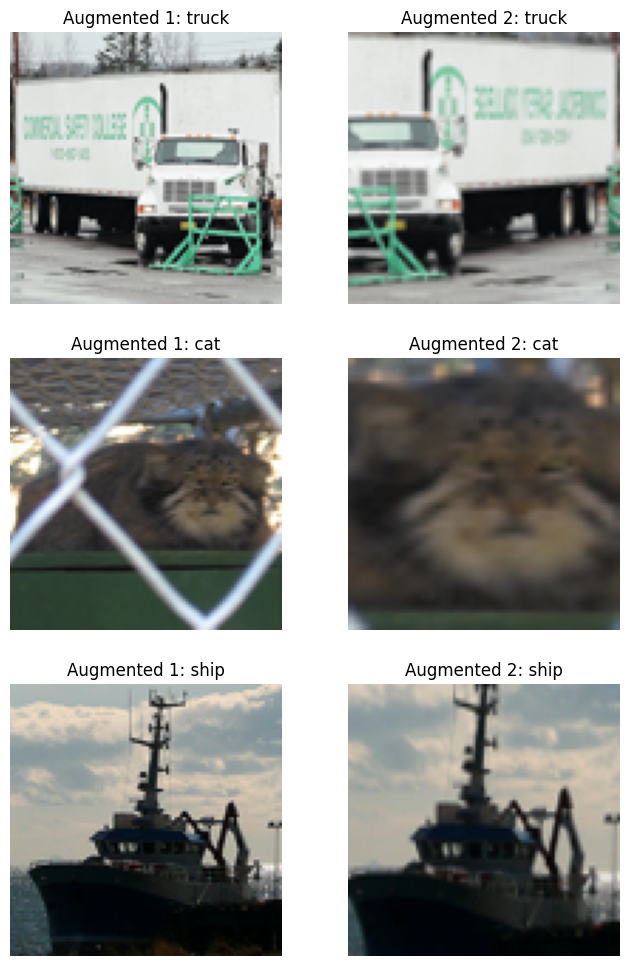

In [11]:
# 取得データの確認
import matplotlib.pyplot as plt

# サンプルループ（1バッチ分のデータを取得）
for batch in dataloader:
    augmented_1, augmented_2, labels = batch
    print(f"Augmented 1 shape: {augmented_1.shape}, Augmented 2 shape: {augmented_2.shape}")
    break

#next(iter(dataloader)) # num_workers と，next(iter(dataloader)) の組み合わせはデッドロックを生じさせる可能性あり
fig, ax = plt.subplots(3, 2, figsize=(8, 12))
for i in range(3):
    ax[i, 0].imshow(augmented_1[i].permute(1, 2, 0))
    ax[i, 1].imshow(augmented_2[i].permute(1, 2, 0))
    ax[i, 0].set_title(f"Augmented 1: {labels_map[labels[i].item()]}")
    ax[i, 1].set_title(f"Augmented 2: {labels_map[labels[i].item()]}")
    ax[i, 0].axis("off")
    ax[i, 1].axis("off")
    

ネットワークの構成としては，表現を得るためのモデル(`encoder`)と，その表現を投影し似ているかどうかを判定するためのモデル(`projector`)を規定します．

In [12]:
class SimpleCNN(nn.Module):
    def __init__(self, W, H):
        super(SimpleCNN, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1), # 3xWxH -> 64xWxH
            nn.ReLU(),
            nn.MaxPool2d(2), # 64xWxH -> 64x(W/2)x(H/2)
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2), # 64x(W/4)x(H/4)
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2), # 64x(W/8)x(H/8)
            nn.Flatten() # 64x(W/8)x(H/8) -> 64*(W/8)*(H/8)
        )
        self.projector = nn.Sequential(
            nn.Linear(64*(W//8)*(H//8), 64),
            nn.ReLU(),
            nn.Linear(64, 64)
        )

    def forward(self, x):
        x = self.encoder(x)
        x = x.view(x.size(0), -1)
        x = self.projector(x)
        return x

損失関数は，投影された先の特徴量間の類似度を,正例の場合は大きく，負例の場合は小さくなるように設計します．
これは NT-Xent 関数と呼ばれ，下記のように定義されます．

In [13]:
# NT-Xent Loss の実装例
# 同じ画像から作られたペア→正例
# 異なる画像から作られたペア→負例
# 正例同士は似て，負例同士は異なるようにロスを設計する

def nt_xent_loss(z1, z2, temperature):
    z = torch.cat([z1, z2], dim=0)
    n = z.size(0)
    sim_matrix = torch.matmul(z, z.T) / temperature
    # 数値安定性を考慮して，行の最大値を基準に差っ引いとく
    sim_matrix = sim_matrix - torch.max(sim_matrix, dim=1, keepdim=True)[0]
    sim_matrix = torch.exp(sim_matrix)

    # 対角成分は同じ画像同士の類似度なので正例，それ以外が負例
    mask = (torch.ones_like(sim_matrix) - torch.eye(n, device=sim_matrix.device)).bool()
    pos_sim = sim_matrix[range(n), range(n)]
    neg_sim = sim_matrix[mask].reshape(n, -1)

    loss = -torch.log(pos_sim / (pos_sim + neg_sim.sum(dim=-1)))
    loss = loss.mean()
    return loss



さらに学習ループは，下記のようにかきます．

In [14]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = SimpleCNN(W, H).to(device)

optimizer = optim.Adam(model.parameters(), lr=1e-3)

history = [] # 学習履歴
num_epochs = 15 # エポック数，性能に合わせて調整

for epoch in range(num_epochs):
    for (images1, images2, _) in dataloader:
        images1, images2 = images1.to(device), images2.to(device)

        # 特徴抽出→projector
        z1 = model(images1)
        z2 = model(images2)

        # 類似性損失: NT-Xent 損失を計算
        loss = nt_xent_loss(z1, z2, temperature=0.4)  # temperature はハイパーパラメータ

        history.append(loss.item())

        # 学習
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f"Epoch {epoch+1}, Loss: {loss.item()}")


Epoch 1, Loss: 4.6890997886657715
Epoch 2, Loss: 3.057441234588623
Epoch 3, Loss: 1.122199535369873
Epoch 4, Loss: 0.240477055311203
Epoch 5, Loss: 0.1540427803993225
Epoch 6, Loss: 0.11431563645601273
Epoch 7, Loss: 0.05894764885306358
Epoch 8, Loss: 0.08503246307373047
Epoch 9, Loss: 0.07172290980815887
Epoch 10, Loss: 0.04281484708189964
Epoch 11, Loss: 0.08046001940965652
Epoch 12, Loss: 0.13785724341869354
Epoch 13, Loss: 0.0802868977189064
Epoch 14, Loss: 0.051190514117479324
Epoch 15, Loss: 0.01807796023786068


多分，これでなんとか回って，ロスが下がるはずです．

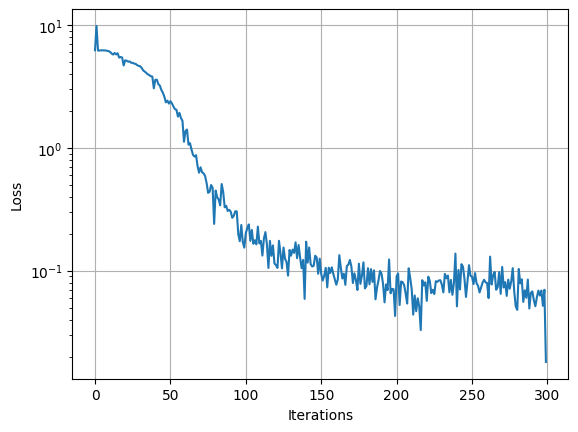

In [15]:
# history のプロット
plt.semilogy(history)
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.grid()


`SimpleCNN.encoder` がうまく学習できていればよいな，と思って性能を測ってみます．

In [26]:
#train_dataset = datasets.CIFAR10(root="./data", train=True, download=True, transform=transform_original)
#test_dataset = datasets.CIFAR10(root="./data", train=False, download=True, transform=transform_original)
train_dataset = datasets.STL10(root="./data", split='train', download=True, transform=transform_original)
test_dataset = datasets.STL10(root="./data", split='test', download=True, transform=transform_original)

train_ratio = 1.0 # 学習パターンを使う割合
num_train_samples = int(len(train_dataset) * train_ratio)
subset_train_dataset, _ = torch.utils.data.random_split(train_dataset, [num_train_samples, len(train_dataset) - num_train_samples])

train_dataloader = DataLoader(subset_train_dataset, batch_size=64, shuffle=True, num_workers=4)
test_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=4)

Files already downloaded and verified
Files already downloaded and verified


Epoch 1, Loss: 1.990572751322879
Epoch 2, Loss: 1.7964419745191742
Epoch 3, Loss: 1.7173500890973248
Epoch 4, Loss: 1.6667303329781642
Epoch 5, Loss: 1.6151183888882021
Epoch 6, Loss: 1.5760605350325378
Epoch 7, Loss: 1.5365615615361854
Epoch 8, Loss: 1.495941097223306
Epoch 9, Loss: 1.4690945133378235
Epoch 10, Loss: 1.4320177790484852
Epoch 11, Loss: 1.4087562032892733
Epoch 12, Loss: 1.381387766403488
Epoch 13, Loss: 1.3629938696004167
Epoch 14, Loss: 1.3288699629940564
Epoch 15, Loss: 1.3105946447275862
Epoch 16, Loss: 1.2891399483137493
Epoch 17, Loss: 1.2729551022565817
Epoch 18, Loss: 1.241672063175636
Epoch 19, Loss: 1.2233690468570855
Epoch 20, Loss: 1.2018574815762193
Epoch 21, Loss: 1.1862014328377157
Epoch 22, Loss: 1.1592452156392834
Epoch 23, Loss: 1.1535892660104776
Epoch 24, Loss: 1.1318692670592778
Epoch 25, Loss: 1.1210309417941902
Epoch 26, Loss: 1.1028878718991824
Epoch 27, Loss: 1.087619666057297
Epoch 28, Loss: 1.0732940608942056
Epoch 29, Loss: 1.0496854148333585

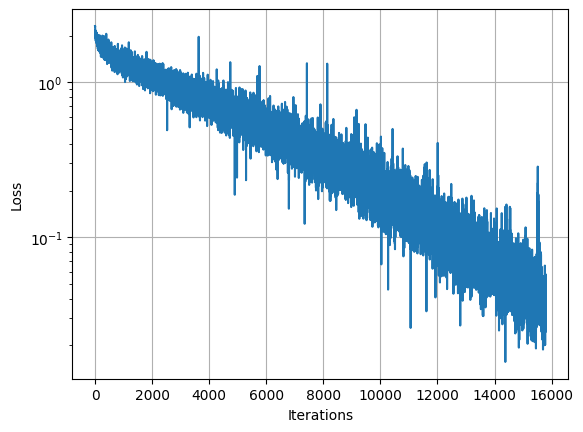

In [33]:
# 特徴抽出層は上で学習したものを固定して使う
for param in model.parameters():
    param.requires_grad = False

# 簡単な分類器を訓練 3層のMLP
classifier = nn.Sequential(
    nn.Linear(64*(W//8)*(H//8), 128),
    nn.ReLU(),
    nn.Linear(128, 10).to(device)
).to(device)

optimizer = optim.Adam(classifier.parameters(), lr=5e-4)
criterion = nn.CrossEntropyLoss()

history = []

# ラベルを使って学習
num_epochs = 200
for epoch in range(num_epochs):
    average_loss = 0.0
    for (images, labels) in train_dataloader:
        images, labels = images.to(device), labels.to(device)
        features = model.encoder(images)
        outputs = classifier(features)

        loss = criterion(outputs, labels)
        history.append(loss.item())
        average_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    average_loss /= len(train_dataloader)
    print(f"Epoch {epoch+1}, Loss: {average_loss}")
    
plt.semilogy(history)
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.grid()

Accuracy: 0.9988


Text(0.5, 1.0, 'Confusion Matrix0.9988')

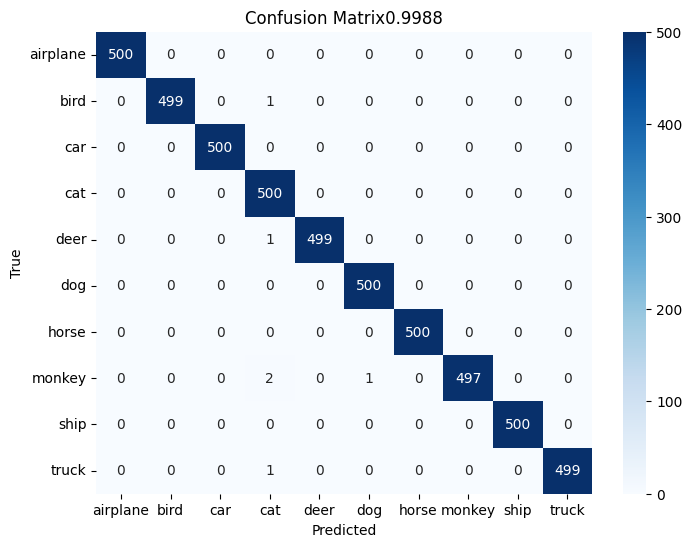

In [34]:
# 識別性能をテストデータ測る
# ついでに混同行列も作成

from sklearn.metrics import confusion_matrix
import seaborn as sns
import numpy as np

conf_matrix = np.zeros((10, 10))
with torch.no_grad():
    for (images, labels) in test_dataloader:
        images, labels = images.to(device), labels.to(device)
        features = model.encoder(images)
        outputs = classifier(features)
        _, predicted = torch.max(outputs, 1)
        conf_matrix += confusion_matrix(labels.cpu().numpy(), predicted.cpu().numpy(), labels=np.arange(10))

conf_matrix = np.array(conf_matrix, dtype=int)
correct = np.sum(np.diag(conf_matrix))
total = np.sum(conf_matrix)
print(f"Accuracy: {correct / total:.4f}")


plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=labels_map, yticklabels=labels_map)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix{:.4f}".format(correct / total))


# 実験3-5

1. 自己教師あり学習による識別器を構成し，`CIFAR10` を用いた場合の識別性能を評価しなさい．（識別器はロジスティック回帰やSVM を用いて構わない）
2. 自己教師あり学習によって得られた `CIFAR10` の特徴表現を，PCA や t-SNE を用いて図示し，各クラスのデータが構造を持つかどうかを考察しなさい．
3. 自己教師あり学習によって得られた `CIFAR10` の特徴表現を k-means 法によりクラスタリングを行い，自己教師あり学習の特徴がクラスタリングに有効かどうかを評価しなさい．